# Recurrent Neural Network

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


### Data Loading

In [2]:
df = pd.read_csv("BTC-USD.csv")

## Data Preprocess

In [3]:
#  Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [4]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2017-06-23,0.046397
2017-06-24,0.038645
2017-06-25,0.037546
2017-06-26,0.031230
2017-06-27,0.035442


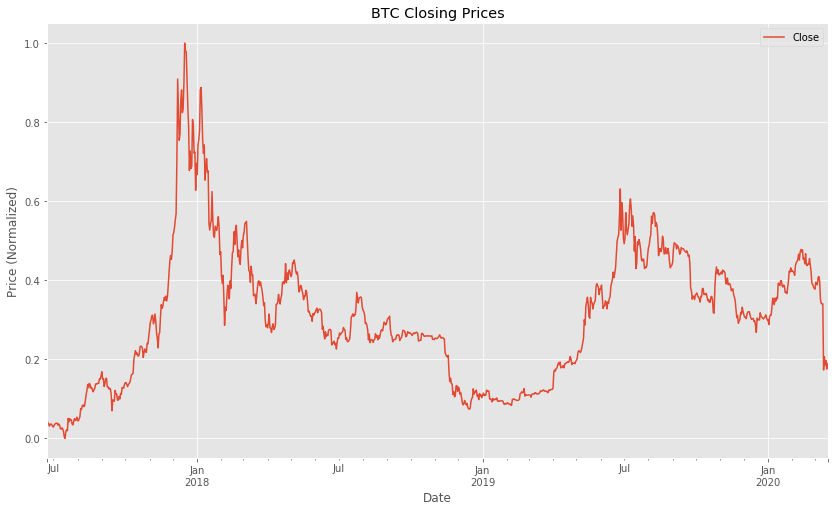

In [5]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

## Functions to prepare the data for LTSM

In [6]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [7]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

## Splitting the Data

In [9]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

## Modeling - LSTM (RNN)

### Creating the Neural Network

In [10]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 12)           

In [11]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [ ]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Train on 864 samples, validate on 97 samples
Epoch 1/800
864/864 [==============================] - 7s 8ms/step - loss: 0.1028 - accuracy: 0.0729 - val_loss: 0.0733 - val_accuracy: 0.0825
Epoch 2/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0540 - accuracy: 0.0671 - val_loss: 0.0222 - val_accuracy: 0.0825
Epoch 3/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0332 - accuracy: 0.0729 - val_loss: 0.0090 - val_accuracy: 0.0619
Epoch 4/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0296 - accuracy: 0.0868 - val_loss: 0.0069 - val_accuracy: 0.1856
Epoch 5/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0226 - accuracy: 0.1678 - val_loss: 0.0066 - val_accuracy: 0.1546
Epoch 6/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0156 - accuracy: 0.0810 - val_loss: 0.0068 - val_accuracy: 0.0619
Epoch 7/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0141 - accuracy: 0.0

864/864 [==============================] - 2s 2ms/step - loss: 0.0033 - accuracy: 0.1447 - val_loss: 0.0030 - val_accuracy: 0.1443
Epoch 58/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0032 - accuracy: 0.1632 - val_loss: 0.0035 - val_accuracy: 0.0722
Epoch 59/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0031 - accuracy: 0.1308 - val_loss: 0.0028 - val_accuracy: 0.1237
Epoch 60/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0032 - accuracy: 0.1586 - val_loss: 0.0034 - val_accuracy: 0.0825
Epoch 61/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0034 - accuracy: 0.1366 - val_loss: 0.0030 - val_accuracy: 0.1443
Epoch 62/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0031 - accuracy: 0.1458 - val_loss: 0.0035 - val_accuracy: 0.1340
Epoch 63/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0031 - accuracy: 0.1632 - val_loss: 0.0032 - val_accuracy: 0.1649
Epoch

Epoch 114/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.1840 - val_loss: 0.0041 - val_accuracy: 0.1443
Epoch 115/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.2014 - val_loss: 0.0053 - val_accuracy: 0.1443
Epoch 116/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0021 - accuracy: 0.1806 - val_loss: 0.0042 - val_accuracy: 0.1443
Epoch 117/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.1852 - val_loss: 0.0044 - val_accuracy: 0.1649
Epoch 118/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.1690 - val_loss: 0.0043 - val_accuracy: 0.1134
Epoch 119/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.1794 - val_loss: 0.0039 - val_accuracy: 0.1443
Epoch 120/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0020 - accuracy: 0.1736 - val_loss: 0.0048 - val_ac

864/864 [==============================] - 2s 2ms/step - loss: 0.0013 - accuracy: 0.2014 - val_loss: 0.0044 - val_accuracy: 0.1237
Epoch 171/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.1968 - val_loss: 0.0030 - val_accuracy: 0.1237
Epoch 172/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.2326 - val_loss: 0.0040 - val_accuracy: 0.1134
Epoch 173/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0016 - accuracy: 0.2141 - val_loss: 0.0030 - val_accuracy: 0.1031
Epoch 174/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0015 - accuracy: 0.2292 - val_loss: 0.0041 - val_accuracy: 0.1134
Epoch 175/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.2188 - val_loss: 0.0031 - val_accuracy: 0.1134
Epoch 176/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.1991 - val_loss: 0.0043 - val_accuracy: 0.0825

864/864 [==============================] - 2s 2ms/step - loss: 0.0010 - accuracy: 0.2465 - val_loss: 0.0037 - val_accuracy: 0.1546
Epoch 227/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0010 - accuracy: 0.2338 - val_loss: 0.0031 - val_accuracy: 0.1443
Epoch 228/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.2326 - val_loss: 0.0044 - val_accuracy: 0.1546
Epoch 229/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0011 - accuracy: 0.2280 - val_loss: 0.0035 - val_accuracy: 0.1443
Epoch 230/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.2257 - val_loss: 0.0039 - val_accuracy: 0.0928
Epoch 231/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0010 - accuracy: 0.2500 - val_loss: 0.0033 - val_accuracy: 0.1649
Epoch 232/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0010 - accuracy: 0.2361 - val_loss: 0.0033 - val_accuracy: 0.1546

Epoch 282/800
864/864 [==============================] - 2s 2ms/step - loss: 7.7415e-04 - accuracy: 0.2431 - val_loss: 0.0038 - val_accuracy: 0.1856
Epoch 283/800
864/864 [==============================] - 2s 2ms/step - loss: 7.6304e-04 - accuracy: 0.2500 - val_loss: 0.0030 - val_accuracy: 0.1856
Epoch 284/800
864/864 [==============================] - 2s 2ms/step - loss: 8.5072e-04 - accuracy: 0.2523 - val_loss: 0.0036 - val_accuracy: 0.2371
Epoch 285/800
864/864 [==============================] - 2s 2ms/step - loss: 9.1723e-04 - accuracy: 0.2373 - val_loss: 0.0038 - val_accuracy: 0.1649
Epoch 286/800
864/864 [==============================] - 2s 2ms/step - loss: 8.7144e-04 - accuracy: 0.2477 - val_loss: 0.0032 - val_accuracy: 0.1959
Epoch 287/800
864/864 [==============================] - 2s 2ms/step - loss: 8.4572e-04 - accuracy: 0.2674 - val_loss: 0.0031 - val_accuracy: 0.1649
Epoch 288/800
864/864 [==============================] - 2s 2ms/step - loss: 7.9491e-04 - accuracy: 0.2431

864/864 [==============================] - 2s 2ms/step - loss: 7.0024e-04 - accuracy: 0.2859 - val_loss: 0.0039 - val_accuracy: 0.1753
Epoch 338/800
864/864 [==============================] - 2s 2ms/step - loss: 7.3201e-04 - accuracy: 0.2662 - val_loss: 0.0041 - val_accuracy: 0.1546
Epoch 339/800
864/864 [==============================] - 2s 2ms/step - loss: 6.8579e-04 - accuracy: 0.2743 - val_loss: 0.0037 - val_accuracy: 0.2062
Epoch 340/800
864/864 [==============================] - 2s 2ms/step - loss: 6.9252e-04 - accuracy: 0.2697 - val_loss: 0.0039 - val_accuracy: 0.1649
Epoch 341/800
864/864 [==============================] - 2s 2ms/step - loss: 6.7907e-04 - accuracy: 0.2627 - val_loss: 0.0039 - val_accuracy: 0.1856
Epoch 342/800
864/864 [==============================] - 2s 2ms/step - loss: 7.4742e-04 - accuracy: 0.2894 - val_loss: 0.0043 - val_accuracy: 0.2062
Epoch 343/800
864/864 [==============================] - 2s 2ms/step - loss: 7.5972e-04 - accuracy: 0.2859 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 0.0018 - accuracy: 0.2396 - val_loss: 0.0043 - val_accuracy: 0.1237
Epoch 393/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0021 - accuracy: 0.2558 - val_loss: 0.0037 - val_accuracy: 0.1134
Epoch 394/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0013 - accuracy: 0.2697 - val_loss: 0.0049 - val_accuracy: 0.1649
Epoch 395/800
864/864 [==============================] - 2s 2ms/step - loss: 8.7827e-04 - accuracy: 0.2604 - val_loss: 0.0040 - val_accuracy: 0.1856
Epoch 396/800
864/864 [==============================] - 2s 2ms/step - loss: 7.2097e-04 - accuracy: 0.2812 - val_loss: 0.0036 - val_accuracy: 0.1753
Epoch 397/800
864/864 [==============================] - 2s 2ms/step - loss: 6.6193e-04 - accuracy: 0.2859 - val_loss: 0.0041 - val_accuracy: 0.1856
Epoch 398/800
864/864 [==============================] - 2s 2ms/step - loss: 6.5991e-04 - accuracy: 0.3102 - val_loss: 0.0044 - val_

864/864 [==============================] - 2s 2ms/step - loss: 5.9182e-04 - accuracy: 0.2917 - val_loss: 0.0040 - val_accuracy: 0.1959
Epoch 448/800
864/864 [==============================] - 2s 2ms/step - loss: 5.6909e-04 - accuracy: 0.2940 - val_loss: 0.0039 - val_accuracy: 0.1856
Epoch 449/800
864/864 [==============================] - 2s 2ms/step - loss: 5.8792e-04 - accuracy: 0.2720 - val_loss: 0.0037 - val_accuracy: 0.1856
Epoch 450/800
864/864 [==============================] - 2s 2ms/step - loss: 5.8780e-04 - accuracy: 0.2998 - val_loss: 0.0036 - val_accuracy: 0.1856
Epoch 451/800
864/864 [==============================] - 2s 2ms/step - loss: 5.5073e-04 - accuracy: 0.3044 - val_loss: 0.0040 - val_accuracy: 0.1959
Epoch 452/800
864/864 [==============================] - 2s 2ms/step - loss: 5.5312e-04 - accuracy: 0.2986 - val_loss: 0.0040 - val_accuracy: 0.1753
Epoch 453/800
864/864 [==============================] - 2s 2ms/step - loss: 5.6906e-04 - accuracy: 0.2951 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 5.1306e-04 - accuracy: 0.2917 - val_loss: 0.0038 - val_accuracy: 0.1959
Epoch 503/800
864/864 [==============================] - 2s 2ms/step - loss: 5.3734e-04 - accuracy: 0.2650 - val_loss: 0.0039 - val_accuracy: 0.1959
Epoch 504/800
864/864 [==============================] - 2s 2ms/step - loss: 5.1174e-04 - accuracy: 0.3206 - val_loss: 0.0037 - val_accuracy: 0.1856
Epoch 505/800
864/864 [==============================] - 2s 2ms/step - loss: 5.0684e-04 - accuracy: 0.2766 - val_loss: 0.0038 - val_accuracy: 0.2062
Epoch 506/800
864/864 [==============================] - 2s 2ms/step - loss: 5.3116e-04 - accuracy: 0.2940 - val_loss: 0.0036 - val_accuracy: 0.1856
Epoch 507/800
864/864 [==============================] - 2s 2ms/step - loss: 5.0472e-04 - accuracy: 0.2917 - val_loss: 0.0042 - val_accuracy: 0.2062
Epoch 508/800
864/864 [==============================] - 2s 2ms/step - loss: 5.0291e-04 - accuracy: 0.2859 - val_loss: 0

### Plotting the Accuracy and Loss

In [ ]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model

Plotting the difference between Actual closing prices and the Predicted prices.

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

In [ ]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 20

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()